## Install & Import Libraries & Get Data

In [ ]:
# Code to read csv file into Colaboratory:
!pip -q install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
id = '1bj0yDcTdBedCTQWKaC0JpidjC8QS8Tqz'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('combined_data.csv') 

In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error #, mean_absolute_percentage_error
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

## Data Cleaning

In [ ]:
df = pd.read_csv("/content/combined_data.csv")

In [ ]:
# Remove 0 popularity
df = df[df.popularity != 0]

# Convert album_type to categorical
df["album_type"] = list(map(lambda x: 0 if x == "single" else 1 if x == "album" else 2, df["album_type"]))

# Drop irrelevant columns for model
df.drop(["is_local", "time_signature", "artists", "album_name", "name"], axis=1, inplace=True)

In [ ]:
df

,album_type,total_tracks,explicit,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,1,16,True,80,0.794,0.766,9,-3.894,0,0.0377,0.01350,0.000000,0.0785,0.550,127.007,195873
1,1,11,False,43,0.626,0.457,4,-13.785,1,0.0384,0.35500,0.000009,0.0668,0.474,102.166,184267
2,1,10,False,82,0.523,0.606,1,-4.754,0,0.0301,0.51200,0.000000,0.1060,0.065,145.837,217867
3,0,6,False,42,0.417,0.443,5,-6.261,1,0.0328,0.70900,0.000000,0.2170,0.470,119.903,155342
4,0,6,True,81,0.247,0.438,5,-8.479,1,0.0358,0.04550,0.000871,0.1110,0.390,185.716,198213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13277,1,12,False,1,0.439,0.891,0,-4.764,1,0.0570,0.01220,0.000000,0.5470,0.695,148.599,168000
13278,1,12,False,66,0.568,0.495,1,-8.964,1,0.0299,0.35300,0.000000,0.0839,0.303,128.234,281067
13280,1,11,False,40,0.664,0.622,10,-8.505,1,0.0253,0.09940,0.073800,0.1120,0.614,102.342,310333
13281,1,13,False,60,0.738,0.541,1,-5.485,1,0.0311,0.55900,0.000000,0.0492,0.309,134.187,387573


## Metrics & Split Data

In [ ]:
# Credits: https://www.codegrepper.com/code-examples/python/scikit+learn+metrics+mape
# Due to Python version in Google Colaboratory is 3.7, which is lower than 3.8 required for sklearn.metrics.mean_absolute_percentage_error,
# this alternative code was used which gives the same result.
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred))))

def get_scores(y_train, y_test, train_pred, preds):
    # R^2
    test_r2 = r2_score(y_test, preds)
    train_r2 = r2_score(y_train, train_pred)

    # RMSE (Root Mean Squared Error)
    test_rmse = np.sqrt(mean_squared_error(y_test, preds))
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))

    # MAE (Mean Absolute Error)
    test_mae = mean_absolute_error(y_test, preds)
    train_mae = mean_absolute_error(y_train, train_pred)

    # MAPE (Mean Absolute Percentage Error)
    test_mape = mean_absolute_percentage_error(y_test, preds)
    train_mape = mean_absolute_percentage_error(y_train, train_pred)

    print("Train R^2: {}".format(train_r2))
    print("Test R^2: {}".format(test_r2))
    print("Train RMSE: {}".format(train_rmse))
    print("Test RMSE: {}".format(test_rmse))
    print("Train MAE: {}".format(train_mae))
    print("Test MAE: {}".format(test_mae))
    print("Train MAPE: {}".format(train_mape))
    print("Test MAPE: {}".format(test_mape))

    return

In [ ]:
X, y = df.iloc[:,df.columns != 'popularity'],df.iloc[:,df.columns == 'popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3101)

print("Size of training data = " + str(X_train.shape[0]))
print("Size of testing data = " + str(X_test.shape[0]))

Size of training data = 9118
Size of testing data = 2280


## XGBRegressor

In [ ]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', 
                          seed = 3101)

In [ ]:
xg_reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=3101, silent=None, subsample=1, verbosity=1)

In [ ]:
preds = xg_reg.predict(X_test)
train_pred = xg_reg.predict(X_train)

In [ ]:
get_scores(y_train, y_test, train_pred, preds)

Train R^2: 0.6892885464597607
Test R^2: 0.6283451887318668
Train RMSE: 15.68975595883515
Test RMSE: 17.236100299974105
Train MAE: 11.004591184342004
Test MAE: 12.010191407381443
Train MAPE: 1.2740032274017108
Test MAPE: 1.4843137520700187


## GridSearchCV + XGBRegressor



Warning: GridSearchCV would take around 20mins+ for complete execution

In [ ]:
# params = { 'max_depth': [3,6,10],
#            'learning_rate': [0.01, 0.05, 0.1],
#            'n_estimators': [100, 500, 1000],
#            'colsample_bytree': [0.3, 0.7]}

# xgbr = xgb.XGBRegressor(seed = 3101)
# clf = GridSearchCV(estimator=xgbr, 
#                    param_grid=params,
#                    scoring='neg_mean_squared_error', 
#                    verbose=1)
# clf.fit(X_train, y_train)

In [ ]:
#print("Best parameters:", clf.best_params_)

In [ ]:
xg_reg_gridsearch = xgb.XGBRegressor(objective ='reg:squarederror', 
                                     colsample_bytree = 0.7, 
                                     learning_rate = 0.01,
                                     max_depth = 10, 
                                     n_estimators = 1000, 
                                     seed = 3101)

In [ ]:
xg_reg_gridsearch.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=3101, silent=None, subsample=1, verbosity=1)

In [ ]:
grid_preds = xg_reg_gridsearch.predict(X_test)
grid_train_pred = xg_reg_gridsearch.predict(X_train)

In [ ]:
get_scores(y_train, y_test, grid_train_pred, grid_preds)

Train R^2: 0.9705054226871068
Test R^2: 0.6808599006514439
Train RMSE: 4.834022255760284
Test RMSE: 15.972019102511943
Train MAE: 3.206185429020131
Test MAE: 10.724252219210591
Train MAPE: 0.2623520310586808
Test MAPE: 1.21076725815355


## GridSearchCV + smoteR + XGBRegressor

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relevance(x):
    x = np.array(x)
    return sigmoid(x - 50)

def get_synth_cases(D, target, o=200, k=3, categorical_col = []):
    '''
    Function to generate the new cases.
    INPUT:
        D - pd.DataFrame with the initial data
        target - string name of the target column in the dataset
        o - oversampling rate
        k - number of nearest neighbors to use for the generation
        categorical_col - list of categorical column names
    OUTPUT:
        new_cases - pd.DataFrame containing new generated cases
    '''
    np.random.seed(3101)
    new_cases = pd.DataFrame(columns = D.columns) # initialize the list of new cases 
    ng = o // 100 # the number of new cases to generate
    for index, case in D.iterrows():
        # find k nearest neighbors of the case
        knn = KNeighborsRegressor(n_neighbors = k+1) # k+1 because the case is the nearest neighbor to itself
        knn.fit(D.drop(columns = [target]).values, D[[target]])
        neighbors = knn.kneighbors(case.drop(labels = [target]).values.reshape(1, -1), return_distance=False).reshape(-1)
        neighbors = np.delete(neighbors, np.where(neighbors == index))
        for i in range(0, ng):
            # randomly choose one of the neighbors
            x = D.iloc[neighbors[np.random.randint(k)]]
            attr = {}          
            for a in D.columns:
                # skip target column
                if a == target:
                    continue;
                if a in categorical_col:
                    # if categorical then choose randomly one of values
                    if np.random.randint(2) == 0:
                        attr[a] = case[a]
                    else:
                        attr[a] = x[a]
                else:
                    # if continious column
                    diff = case[a] - x[a]
                    attr[a] = case[a] + np.random.randint(2) * diff
            # decide the target column
            new = np.array(list(attr.values()))
            d1 = cosine_similarity(new.reshape(1, -1), case.drop(labels = [target]).values.reshape(1, -1))[0][0]
            d2 = cosine_similarity(new.reshape(1, -1), x.drop(labels = [target]).values.reshape(1, -1))[0][0]
            attr[target] = (d2 * case[target] + d1 * x[target]) / (d1 + d2)
            
            # append the result
            new_cases = new_cases.append(attr,ignore_index = True)
                    
    return new_cases

def SmoteR(D, target, th = 0.999, o = 200, u = 100, k = 3, categorical_col = []):
    '''
    The implementation of SmoteR algorithm:
    https://core.ac.uk/download/pdf/29202178.pdf
    INPUT:
        D - pd.DataFrame - the initial dataset
        target - the name of the target column in the dataset
        th - relevance threshold
        o - oversampling rate
        u - undersampling rate
        k - the number of nearest neighbors
    OUTPUT:
        new_D - the resulting new dataset
    '''
    # median of the target variable
    y_bar = D[target].median()
    
    # find rare cases where target less than median
    rareL = D[(relevance(D[target]) > th) & (D[target] < y_bar)]  
    # generate rare cases for rareL
    new_casesL = get_synth_cases(rareL, target, o, k , categorical_col)
    
    # find rare cases where target greater than median
    rareH = D[(relevance(D[target]) > th) & (D[target] > y_bar)]
    # generate rare cases for rareH
    new_casesH = get_synth_cases(rareH, target, o, k , categorical_col)
    
    new_cases = pd.concat([new_casesL, new_casesH], axis=0)
    
    # undersample norm cases
    norm_cases = D[relevance(D[target]) <= th]
    # get the number of norm cases
    nr_norm = int(len(norm_cases) * u / 100)
    
    norm_cases = norm_cases.sample(min(len(D[relevance(D[target]) <= th]), nr_norm))
    
    # get the resulting dataset
    new_D = pd.concat([new_cases, norm_cases], axis=0)
    
    return new_D

In [ ]:
df

,album_type,total_tracks,explicit,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,1,16,True,80,0.794,0.766,9,-3.894,0,0.0377,0.01350,0.000000,0.0785,0.550,127.007,195873
1,1,11,False,43,0.626,0.457,4,-13.785,1,0.0384,0.35500,0.000009,0.0668,0.474,102.166,184267
2,1,10,False,82,0.523,0.606,1,-4.754,0,0.0301,0.51200,0.000000,0.1060,0.065,145.837,217867
3,0,6,False,42,0.417,0.443,5,-6.261,1,0.0328,0.70900,0.000000,0.2170,0.470,119.903,155342
4,0,6,True,81,0.247,0.438,5,-8.479,1,0.0358,0.04550,0.000871,0.1110,0.390,185.716,198213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13277,1,12,False,1,0.439,0.891,0,-4.764,1,0.0570,0.01220,0.000000,0.5470,0.695,148.599,168000
13278,1,12,False,66,0.568,0.495,1,-8.964,1,0.0299,0.35300,0.000000,0.0839,0.303,128.234,281067
13280,1,11,False,40,0.664,0.622,10,-8.505,1,0.0253,0.09940,0.073800,0.1120,0.614,102.342,310333
13281,1,13,False,60,0.738,0.541,1,-5.485,1,0.0311,0.55900,0.000000,0.0492,0.309,134.187,387573


In [ ]:
Xs = SmoteR(df, target='popularity', th = 0.999, o = 300, u = 100, k = 10, 
            categorical_col = ['explicit','key', 'mode', 'album_type'])

In [ ]:
Xs

,album_type,total_tracks,explicit,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,1,8,True,57.5,0.168,0.3260,11,-12.717,1,0.0417,0.074000,0.000010,-0.6882,0.3210,214.069,283753
1,1,11,False,57.0,0.460,-0.2790,1,-10.699,1,0.0417,0.270900,-0.824980,0.0449,0.0940,152.531,283753
2,1,11,False,57.5,0.460,0.1320,7,-13.321,1,0.0417,0.142000,0.000020,0.0449,0.3210,227.594,283753
3,1,13,False,58.0,0.473,0.4440,0,-10.962,1,0.0294,0.670000,0.000000,0.1490,0.7200,170.035,234400
4,1,11,True,57.5,0.473,0.1480,6,-9.065,1,0.0144,0.670000,-0.000080,0.1490,0.4580,170.035,235653
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6105,1,23,True,22.0,0.480,0.8100,5,-6.580,1,0.2720,0.039300,0.000000,0.4310,0.3960,94.691,346107
8276,1,35,False,12.0,0.553,0.8400,7,-2.345,1,0.1020,0.000502,0.001450,0.0300,0.0623,169.975,314868
8551,0,6,False,6.0,0.546,0.4410,2,-6.332,1,0.0251,0.514000,0.000006,0.1280,0.3350,134.917,185946
11715,1,13,False,5.0,0.543,0.9850,4,-2.684,0,0.1240,0.010400,0.000000,0.7610,0.5100,115.084,139732


In [ ]:
Xs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23237 entries, 0 to 11137
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   album_type        23237 non-null  object 
 1   total_tracks      23237 non-null  object 
 2   explicit          23237 non-null  object 
 3   popularity        23237 non-null  float64
 4   danceability      23237 non-null  float64
 5   energy            23237 non-null  float64
 6   key               23237 non-null  object 
 7   loudness          23237 non-null  float64
 8   mode              23237 non-null  object 
 9   speechiness       23237 non-null  float64
 10  acousticness      23237 non-null  float64
 11  instrumentalness  23237 non-null  float64
 12  liveness          23237 non-null  float64
 13  valence           23237 non-null  float64
 14  tempo             23237 non-null  float64
 15  duration_ms       23237 non-null  object 
dtypes: float64(10), object(6)
memory usage: 

In [ ]:
Xs2 = Xs.astype({'album_type': 'int64',
                 'total_tracks': 'int64', 
                 'explicit': 'bool', 
                 'key': 'int64', 
                 'mode': 'int64', 
                 'duration_ms': 'int64'})

In [ ]:
X, y = Xs2.iloc[:,Xs2.columns != 'popularity'],Xs2.iloc[:,Xs2.columns == 'popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3101)

print("Size of training data = " + str(X_train.shape[0]))
print("Size of testing data = " + str(X_test.shape[0]))

Size of training data = 18589
Size of testing data = 4648


In [ ]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', 
                          colsample_bytree = 0.7, 
                          learning_rate = 0.01,
                          max_depth = 10, 
                          n_estimators = 1000, 
                          seed = 3101)

In [ ]:
# For CV
#D_train = xgb.DMatrix(X_train, label=y_train)
#D_test = xgb.DMatrix(X_test, label=y_test)

In [ ]:
xg_reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=3101, silent=None, subsample=1, verbosity=1)

In [ ]:
preds = xg_reg.predict(X_test)
train_pred = xg_reg.predict(X_train)

In [ ]:
get_scores(y_train, y_test, train_pred, preds)

Train R^2: 0.9234382723547739
Test R^2: 0.7530993869053639
Train RMSE: 6.421624482391482
Test RMSE: 11.448581229206798
Train MAE: 3.9201253370214943
Test MAE: 7.248920625254209
Train MAPE: 0.31631820708387265
Test MAPE: 0.6487334653405151


## Pruning through Feature Importance

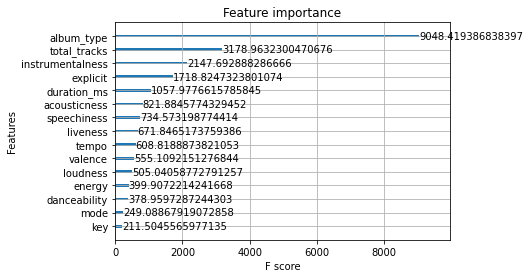

In [ ]:
# plot_importance default matric is "Weight"
# xgb.plot_importance(xg_reg)
# plt.rcParams['figure.figsize'] = [15, 10]
# plt.show()

## However, xg_reg.feature_importances_ is calculated using Gain
xgb.plot_importance(xg_reg, importance_type = "gain")
plt.rcParams['figure.figsize'] = [15, 10]
plt.show()

## The importance type of our model is also Gain
# xg_reg.importance_type

## Reading the documentation for feature_importances reveals that it is calculated using model's importance type 
## and divided by the total sum of these values
# ??xg_reg.feature_importances_


# References
## https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7
## Pruning through feature importance: https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/

In [ ]:
tuning_performance = []
def tune_tree(model, X_train, X_test, y_train, y_test):
    # Obtain thresholds
    main_dict = model.get_booster().get_score(importance_type= "gain")
    total = sum([v for v in main_dict.values()])
    values = [(k,v) for k,v in main_dict.items()]
    thresholds = list(map(lambda x: (x[0], x[1]/total), values))
    thresholds.sort(key=lambda x: x[1])
    
    # Remove least important variable
    var, thresh = thresholds[0]
    select_X_train = X_train.drop(columns=[var])
    select_X_test = X_test.drop(columns=[var])

    # Refit model
    selection_model = xgb.XGBRegressor(objective ='reg:squarederror', 
                      colsample_bytree = 0.7, 
                      learning_rate = 0.01,
                      max_depth = 10, 
                      n_estimators = 1000, 
                      seed = 3101)
    
    selection_model.fit(select_X_train, y_train)
    y_pred = selection_model.predict(select_X_test)
    train_pred = selection_model.predict(select_X_train)

    # Evaluate refitted model
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))

    # Print & Save results
    variables = sorted(list(map(lambda x: x[0], thresholds[1:])))
    print("Variables: {}".format("+".join(variables)))
    print("Number of Variables: {}".format(len(thresholds[1:])))
    print(train_rmse)
    print(test_rmse)
    print("-------------------------------------------------------")

    tuning_performance.append([len(variables), "+".join(variables), train_rmse, test_rmse])
    
    if len(thresholds[1:]) <= 2:
        return
    else:
        tune_tree(selection_model, select_X_train, select_X_test, y_train, y_test)

In [ ]:
tune_tree(xg_reg, X_train, X_test, y_train, y_test)

Variables: acousticness+album_type+danceability+duration_ms+energy+explicit+instrumentalness+liveness+loudness+mode+speechiness+tempo+total_tracks+valence
Number of Variables: 14
6.797955766869808
11.45617730626544
-------------------------------------------------------
Variables: acousticness+album_type+danceability+duration_ms+energy+explicit+instrumentalness+liveness+loudness+speechiness+tempo+total_tracks+valence
Number of Variables: 13
6.771020048659268
11.457800413418754
-------------------------------------------------------
Variables: acousticness+album_type+duration_ms+energy+explicit+instrumentalness+liveness+loudness+speechiness+tempo+total_tracks+valence
Number of Variables: 12
6.859526665260539
11.579147751164928
-------------------------------------------------------
Variables: acousticness+album_type+duration_ms+explicit+instrumentalness+liveness+loudness+speechiness+tempo+total_tracks+valence
Number of Variables: 11
7.336419271203404
11.740426157962924
-----------------

In [ ]:
# Performance of pruned models

## Add back in last Best Model (with no pruning)
tuning_performance.insert(0, [len(X_train.columns), "+".join(sorted(list(X_train.columns))), 6.421624482391482, 11.448581229206798])
pf = pd.DataFrame(tuning_performance)
pf.columns = ["id", "variables", "train_rmse", "test_rmse"]
pf

,id,variables,train_rmse,test_rmse
0,15,acousticness+album_type+danceability+duration_...,6.421624,11.448581
1,14,acousticness+album_type+danceability+duration_...,6.797956,11.456177
2,13,acousticness+album_type+danceability+duration_...,6.771020,11.457800
3,12,acousticness+album_type+duration_ms+energy+exp...,6.859527,11.579148
4,11,acousticness+album_type+duration_ms+explicit+i...,7.336419,11.740426
5,10,acousticness+album_type+duration_ms+explicit+i...,7.349599,11.917020
6,9,acousticness+album_type+duration_ms+explicit+i...,7.846724,12.111249
7,8,acousticness+album_type+duration_ms+explicit+i...,8.320275,12.314741
8,7,acousticness+album_type+duration_ms+explicit+i...,8.736402,12.549419
9,6,album_type+duration_ms+explicit+instrumentalne...,9.384686,12.999412


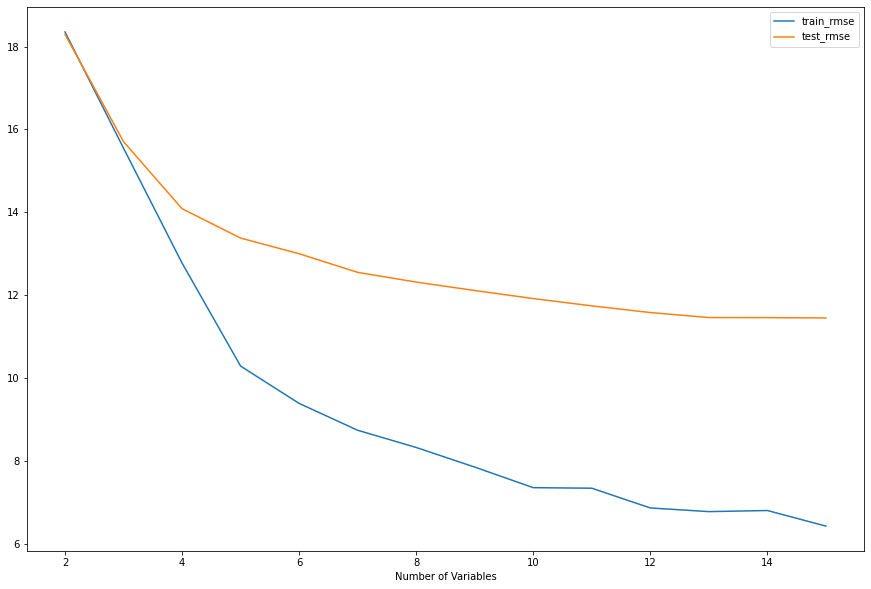

In [ ]:
pf.plot(x="id", xlabel="Number of Variables")

In [ ]:
# Chose to take 12 for a simpler model. Trade-off between rmse score and complexity of model
variables = pf[pf["id"] == 12].variables.values[0]
variables = variables.split("+")

new_X_train = X_train[variables]
new_X_test = X_test[variables]
new_model = xgb.XGBRegressor(objective ='reg:squarederror', 
                  colsample_bytree = 0.7, 
                  learning_rate = 0.01,
                  max_depth = 10, 
                  n_estimators = 1000, 
                  seed=3101)

new_model.fit(new_X_train, y_train)
new_y_pred = new_model.predict(new_X_test)
new_train_pred = new_model.predict(new_X_train)

get_scores(y_train, y_test, new_train_pred, new_y_pred)

Train R^2: 0.9089662514544458
Test R^2: 0.746764732563973
Train RMSE: 7.002292632707638
Test RMSE: 11.594517489502904
Train MAE: 4.271989121147354
Test MAE: 7.334287612711362
Train MAPE: 0.34322721334906947
Test MAPE: 0.6524795917150477


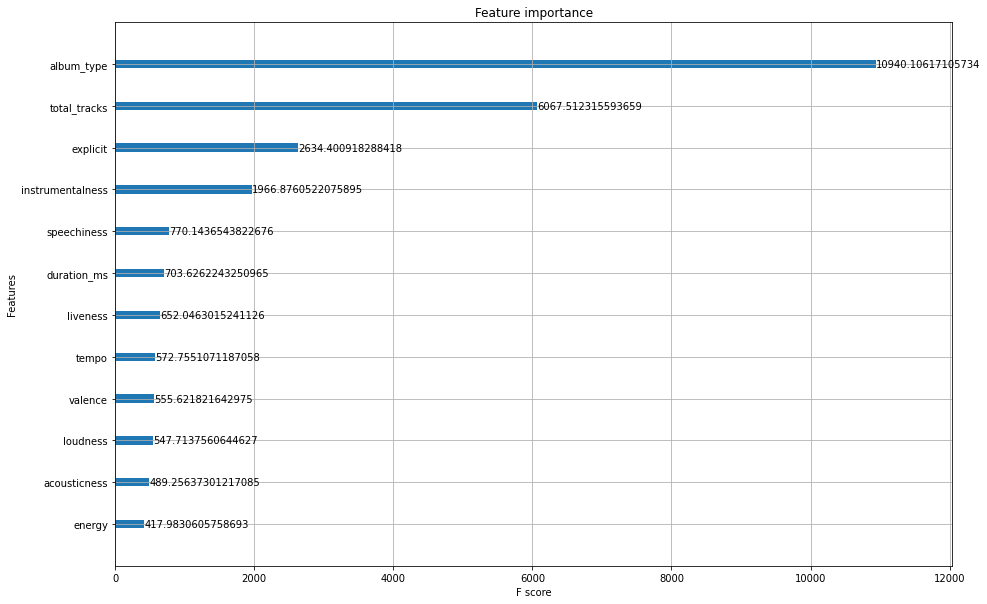

In [ ]:
xgb.plot_importance(new_model, importance_type = "gain")
plt.rcParams['figure.figsize'] = [15, 10]
plt.show()